In [34]:
vector_len = 64

In [35]:
!pip install node2vec tensorflow
!pip install gensim 
from deepwalk_config import *
!pwd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content


In [36]:
# optionally load copy
!7z x copy.zip -o/content


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2502917 bytes (2445 KiB)

Extracting archive: copy.zip
--
Path = copy.zip
Type = zip
Physical Size = 2502917

  0%    
Would you like to replace the existing file:
  Path:     /content/__pycache__/deepwalk_config.cpython-37.pyc
  Size:     11029 bytes (11 KiB)
  Modified: 2022-06-05 17:08:07
with the file from archive:
  Path:     __pycache__/deepwalk_config.cpython-37.pyc
  Size:     11029 bytes (11 KiB)
  Modified: 2022-06-05 17:08:07
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? Q

Archives with Errors: 1



Break signaled


**-------------- Functions --------------**

In [37]:
# choose links from AS file
# samples_number for each link type (peer/customer)

def get_as_data(as_relation_filename, samples_number):
  as_relation_file = open(as_relation_filename, 'r')

  peers = 0
  customers = 0

  X = []
  Y = []

  for line in as_relation_file:
      if line.startswith('#'):
          continue
      data = line.split('|')

      if '0' in data[2]:
          if peers < samples_number:
            X.append([data[0], data[1]])
            Y.append(data[2])
            peers += 1
      else:
          if customers < samples_number:
            X.append([data[0], data[1]])
            Y.append(data[2])
            customers += 1
  return X, Y


def get_as_data2(as_relation_filename, samples_number):
  as_relation_file = open(as_relation_filename, 'r')

  peers = 0

  X = []
  Y = []

  for line in as_relation_file:
      if line.startswith('#'):
          continue
      data = line.split('|')

      if peers < samples_number:
        X.append([data[0], data[1]])
        Y.append(data[2])
        peers += 1
       
  return X, Y

def get_as_data3(as_relation_filename, samples_number, skip):
  as_relation_file = open(as_relation_filename, 'r')

  peers = 0
  skip_ = 0

  X = []
  Y = []

  for line in as_relation_file:
      if line.startswith('#'):
          continue

      if skip_ < skip:
        skip_ += 1
        continue
        
      data = line.split('|')

      if peers < samples_number:
        X.append([data[0], data[1]])
        Y.append(data[2])
        peers += 1
       
  return X, Y



import csv

# create dataset for neural network in format:
# [start_node_embedding], [end_node_embedding], [link_type]
def create_dataset(X, Y, X_embed, dataset_filename):

  out = open(dataset_filename, 'w')
  writer = csv.writer(out)

  for i in range(len(X)):
      data = []
      data.extend(X_embed[X[i][0]])
      data.extend(X_embed[X[i][1]])
      if '0' in Y[i]:
          data.append('0')
      else:
          data.append('1')
      
      writer.writerow(data)

  out.close()


# count links
def display_link_stats(Y):

  peers = 0
  customers = 0

  for y in Y:
      if int(y) == 0:
          peers = peers + 1
      else:
          customers = customers + 1

  print('Peer:', peers, '\n  Customer:', customers)

# embeddings methods ----------------------------------

import networkx as nx
from node2vec import Node2Vec

def node2vec_get_embeddings(as_data):

  embedding_filename = "embeddings_tmp_file"

  # Create a graph 
  graph = nx.Graph()
  for AS in as_data:
      graph.add_edge(AS[0], AS[1])

  # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
  node2vec = Node2Vec(graph, dimensions=vector_len, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

  # Embed nodes
  model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
  
  # Save embeddings for later use
  model.wv.save_word2vec_format(embedding_filename)

  embeddings_file = open(embedding_filename,'r')
  node_embeddings = {}

  i = 0
  for line in embeddings_file:
      if i == 0:
          i = i + 1
          continue
      data = line.split(' ')
      node_embeddings[data[0]] = data[1:]

  return node_embeddings


def deepwalk_get_embeddings(as_data):

  embedding_filename = "embeddings_tmp_file"
 
 # Create a graph 
  graph = nx.Graph()
  for AS in as_data:
      graph.add_edge(AS[0],AS[1])

  # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
  model = DeepWalk(graph,walk_length=10,num_walks=80,workers=1)  # Use temp_folder for big graphs
  
  # Embed nodes
  model.train(embed_size=vector_len)# train model

  # Save embeddings for later use
  model.w2v_model.wv.save_word2vec_format(embedding_filename)

  embeddings_file = open(embedding_filename,'r')
  node_embeddings = {}

  i = 0
  for line in embeddings_file:
      if i == 0:
          i = i + 1
          continue
      data = line.split(' ')
      node_embeddings[data[0]] = data[1:]

  return node_embeddings

**-------------- Create datasets --------------**

In [38]:
#create embeddings and basic dataset
samples = 2000

X, Y = get_as_data('as-rank.caida.peercones-with-IX.txt', samples / 2) # balanced
display_link_stats(Y)

#X_embed = node2vec_get_embeddings(X)
X_embed = deepwalk_get_embeddings(X)
create_dataset(X, Y, X_embed, 'dataset_basic.csv')

Peer: 558 
  Customer: 1000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


Learning embedding vectors...
Learning embedding vectors done!


In [39]:
# create datasets for training and testing
import csv

def split_data(X, Y):
  
  X_0 = []
  Y_0 = []

  X_1 = []
  Y_1 = []

  for i in range(len(X)):
      if Y[i][0] == '0':
        X_0.append(X[i])
        Y_0.append([0])
      else:
        X_1.append(X[i])
        Y_1.append([1])
        
  return X_0, Y_0, X_1, Y_1

def write_csv(filename, X, Y):
  out = open(filename, 'w')
  writer = csv.writer(out)
  for i in range(len(X)):
    data = []
    data.extend(X[i])
    data.extend(Y[i])
    writer.writerow(data)


X = []
Y = []

with open('dataset_basic.csv', mode='r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  for row in csv_reader:
    X.append(row[0:2*vector_len])
    Y.append(row[2*vector_len:])
    

X_0, Y_0, X_1, Y_1 = split_data(X, Y)

X.extend(X_0[0:500])
X.extend(X_1[0:500])

Y.extend(Y_0[0:500])
Y.extend(Y_1[0:500])

write_csv('dataset_balanced.csv', X, Y)

X.clear()
Y.clear()
X.extend(X_0[500:550])
X.extend(X_1[500:550])

Y.extend(Y_0[500:550])
Y.extend(Y_1[500:550])


write_csv('test_dataset_balanced.csv', X, Y)


**---- Train and evaluate model ----**

In [40]:
# create model of neural network

def create_model():
  model = Sequential()
  model.add(Dense(64, input_dim=2*vector_len, activation='relu'))
  model.add(Dense(16, input_dim=2*vector_len, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

K = 1


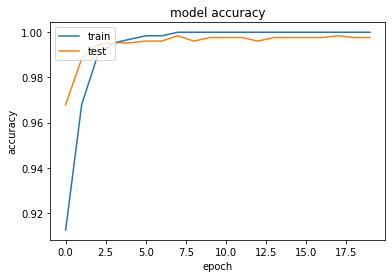

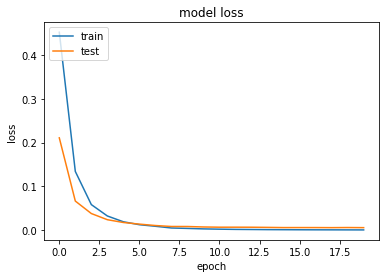

K = 2


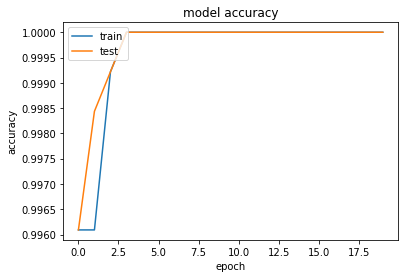

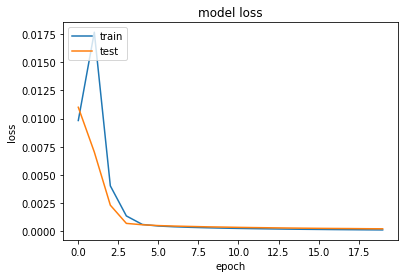

INFO:tensorflow:Assets written to: model/assets


In [41]:
# create, train and save model
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# load dataset
dataframe = read_csv("dataset_balanced.csv", header=None,encoding= 'unicode_escape')
# dataframe = shuffle(dataframe)
dataset = dataframe.values

# split into input (X) and output (Y) variables
X = dataset[:,0:2*vector_len].astype(float)
Y = dataset[:,2*vector_len].astype(int)

# evaluate model with standardized dataset
n_split=2
k = 1

model=create_model()

for train_index,test_index in KFold(n_splits=n_split, shuffle=True).split(X):
	x_train,x_test=X[train_index],X[test_index]
	y_train,y_test=Y[train_index],Y[test_index]
	validation_data = [x_test, y_test];

	print("K =", k);
	k += 1

	
	history = model.fit(x_train, y_train, epochs=20, batch_size=25, validation_data=validation_data, verbose=0)
	
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()


model.save("model")

In [42]:
# evaluate loaded model
from tensorflow import keras
from pandas import read_csv
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

import numpy as np

# load dataset
dataframe = read_csv("test_dataset_balanced.csv", header=None, encoding= 'unicode_escape')

dataset = dataframe.values

# split into input (X) and output (Y) variables
X = dataset[:,0:2*vector_len].astype(float)
Y = dataset[:,2*vector_len]

display_link_stats(Y)

model = keras.models.load_model('model')
predictions = (model.predict(X) > 0.5).astype(int)

success = 0
for i in range(len(X)):
  #print(Y[i], " -> ", predictions[i])
  if int(predictions[i]) == int(Y[i]):
    success += 1

print("Result :", success/len(X)*100)


Peer: 50 
  Customer: 50
Result : 100.0


In [43]:
!rm -rf sample_data
!7z a copy.zip /content/*


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Open archive: copy.zip
--
Path = copy.zip
Type = zip
Physical Size = 2502917

Scanning the drive:
  0M Scan  /content/                    4 folders, 15 files, 11184886 bytes (11 MiB)

Updating archive: copy.zip

Items to compress: 19

  0%     28% 3 U copy.zip                  45% 5 U dataset_basic.csv                           62% 5 U dataset_basic.csv                           78% 7 U embeddings_tmp_file                             90% 7 U embeddings_tmp_file                            
Files read